In [1]:
#The program forecast the consumption of electricity in coming future
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Above is a special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6


In [2]:
df = pd.read_csv('./Electric_Production.csv')

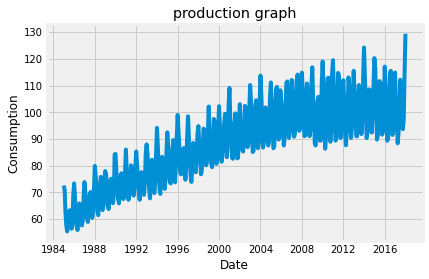

In [3]:
df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

#Visualize the Value
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

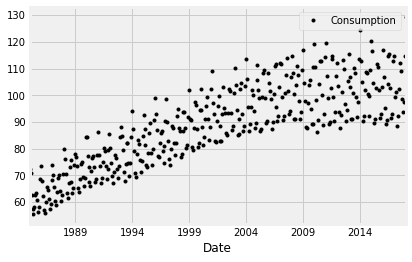

<AxesSubplot:ylabel='Density'>

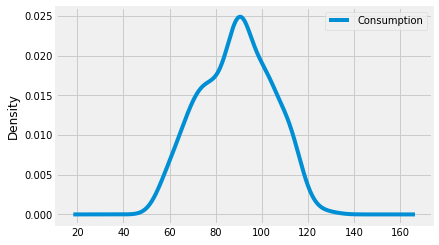

In [4]:
"""
Mean is not constant in this case as we can clearly see an upward trend. 
Hence, we have identified that our series is not stationary. 
We need to have a stationary series to do time series forecasting. 
In the next stage, we will try to convert this into a stationary series.
"""

# scatter plot of the Consumption
df.plot(style='k.')
plt.show()

# Distribution of the dataset
df.plot(kind='kde')
# We can observe a near-normal distribution(bell-curve) over sales values.

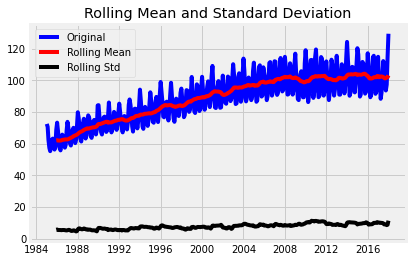

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [5]:
# To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.


"""
The above code has a separated trend and seasonality for us.
This gives us more insight into our data and real-world actions.
Clearly, there is an upward trend and a recurring event where consumption shoot maximum every year!
"""


"""
we need to check if a series is stationary or not.
"""

"""
Following function is a one which can plot a series with it’s rolling mean and standard deviation.
 If both mean and standard deviation are flat lines(constant mean and constant variance),
the series become stationary!
"""




from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    # perform dickey fuller test
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'], autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4], index=[
                       'Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' % key] = values
    print(output)


test_stationarity(df)
# we can see the increasing mean and standard deviation and hence our series is not stationary.

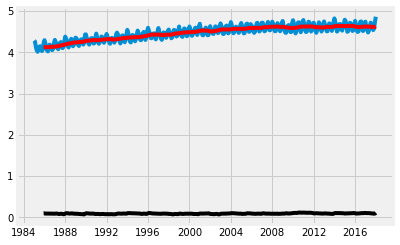

In [6]:
""" Eliminating trend """
"""
we start by taking a log of the series to reduce the magnitude of the values and 
reduce the rising trend in the series. Then after getting the log of the series, 
we find the rolling average of the series. A rolling average is calculated by taking 
input for the past 6 months and giving a mean sales value at every point further ahead in series.
"""
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

In [7]:
"""
After finding the mean, we take the difference of the series and the mean at every point in the series.
This way, we eliminate trend out of a series and obtain a more stationary series.
"""
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

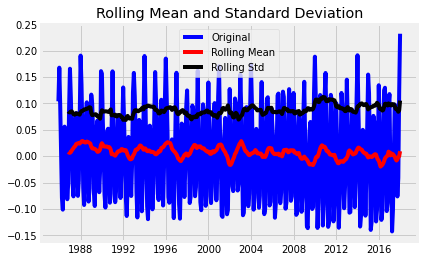

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


In [8]:

"""
Perform dickey fuller test (ADFT) once again. 
This is the actual code for dickey fuller test. 
We have to perform this function everytime to check whether the data 
is stationary or not.
"""
test_stationarity(df_log_moving_avg_diff)
#From the above graph we observed that the data attained stationartiy. We also see that the test statistics and critial value is relatively equal


In [9]:
"""
We need to check the weighted average, to understand the trend of the data in timeseries. 
Take the previous log data nd perform the following operation.
"""
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
print(weighted_average.head())


            Consumption
Date                   
1985-01-01     4.283658
1985-02-01     4.270484
1985-03-01     4.222468
1985-04-01     4.175897
1985-05-01     4.139460


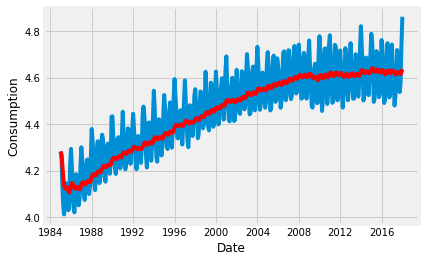

In [10]:
"""
The exponential moving average (EMA) is a weighted average of the last n prices, 
where the weighting decreases exponentially with each previous price/period. 
In other words, the formula gives recent prices more weight than past prices.
"""
plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
#plt.legend()
plt.show(block =False)

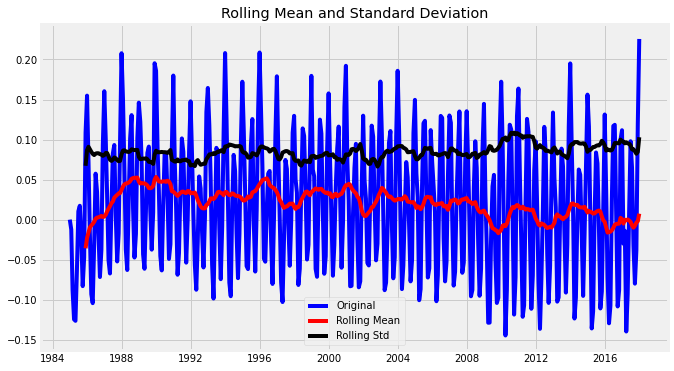

Results of dickey fuller test
Test Statistics                 -3.251531
p-value                          0.017189
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [11]:
"""
Previously we subtracted data_logscale with moving average, now take the same 
log_scale and subtract with weighted_average
"""
from pylab import rcParams
logScale_weightedMean = df_log-weighted_average
# use the same function defined above and pass the object into it.
rcParams['figure.figsize'] = 10, 6
test_stationarity(logScale_weightedMean)

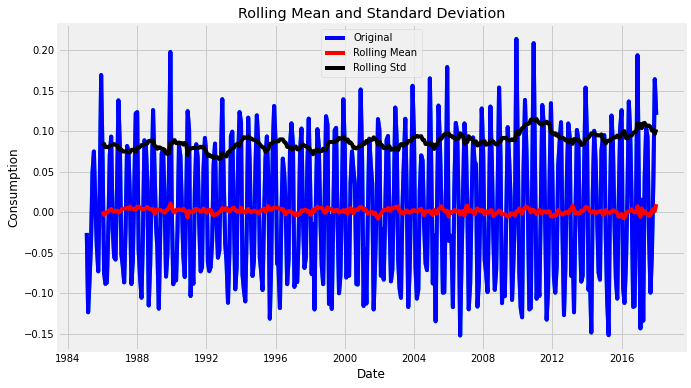

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


In [13]:
"""
There can be cases when there is a high seasonality in the data. 
In those cases, just removing the trend will not help much. 
We need to also take care of the seasonality in the series. 
One such method for this task is differencing!
"""
"""
Differencing is a method of transforming a time series dataset. 
It can be used to remove the series dependence on time, so-called temporal dependence. 
This includes structures like trends and seasonality. Differencing can help stabilize the mean
of the time series by removing changes in the level of a time series, and so eliminating (or reducing) 
trend and seasonality.
Differencing is performed by subtracting the previous observation from the current observation.
"""
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

# Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)

test_stationarity(df_log_diff)
# Now the series is stationary as both maean and std are constant

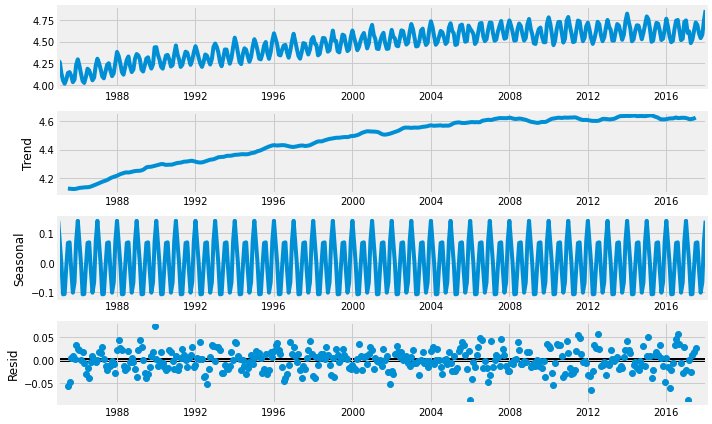

In [15]:
"""
Decomposition
It provides a structured way of thinking about a time series forecasting problem,
 both generally in terms of modelling complexity and specifically in terms of how to best capture
 each of these components in a given model.

"""
result = seasonal_decompose(df_log, model='additive', freq=12)
result.plot()
plt.show()

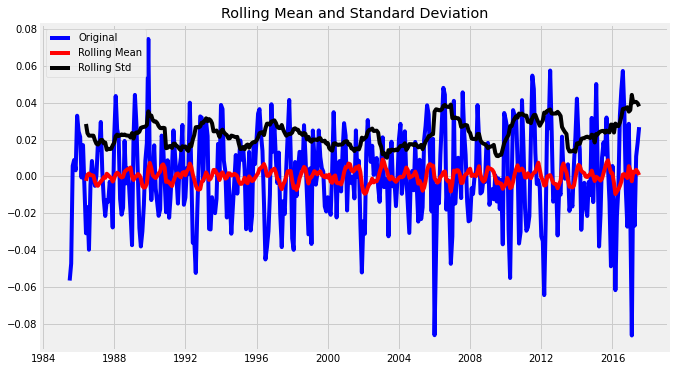

Results of dickey fuller test
Test Statistics               -1.000311e+01
p-value                        1.861632e-17
No. of lags used               1.400000e+01
Number of observations used    3.700000e+02
critical value (1%)           -3.448148e+00
critical value (5%)           -2.869383e+00
critical value (10%)          -2.570948e+00
dtype: float64


In [25]:
trend = result.trend
trend.dropna(inplace=True)

seasonality = result.seasonal
seasonality.dropna(inplace=True)

residual = result.resid
residual.dropna(inplace=True)

a = pd.DataFrame(residual)
a.rename(columns={'resid': 'Consumption'}, inplace=True)
test_stationarity(a)

In [ ]:
"""
After the decomposition, if we look at the residual then we have clearly a flat line for both 
mean and standard deviation. We have got our stationary series and now we can move to model building!!!
"""

In [26]:
# Forecasting
"""
Before we go on to build our forecasting model, 
we need to determine optimal parameters for our model. For those optimal parameters, we need ACF and PACF plots.

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p is the number of autoregressive terms,
d is the number of nonseasonal differences needed for stationarity, and
q is the number of lagged forecast errors in the prediction equation.
Values of p and q come through ACF and PACF plots. So let us understand both ACF and PACF!
"""
"""
#Below code plots, both ACF and PACF plots for us
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
autocorrelation_plot(df_log)
plot_pacf(df_log, lags=10)
plt.show()
"""

# plot acf  and pacf graphs ( auto corellation function and partially auto corellation function )
# to find 'p' from p,d,q we need to use, PACF graphs and for 'q' use ACF graph
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf = pacf(df_log_diff, nlags=15, method='ols')

# ols stands for ordinary least squares used to minimise the errors

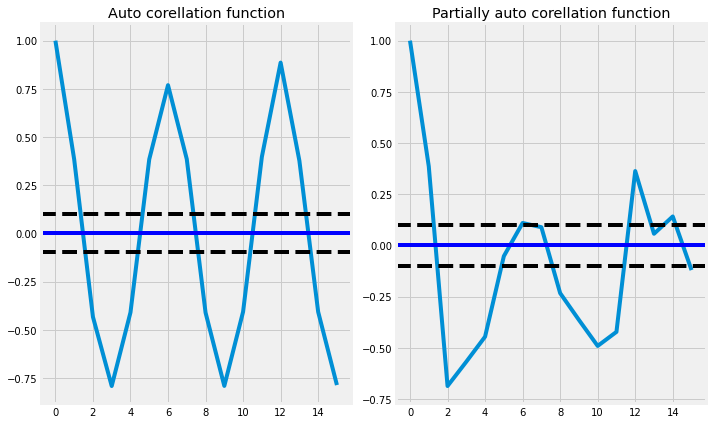

In [27]:
# 121 and 122 makes the data to look side by size

# plot PACF
plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0, linestyle='-', color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.title('Auto corellation function')
plt.tight_layout()


# plot ACF
plt.subplot(122)
plt.plot(pacf)
plt.axhline(y=0, linestyle='-', color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

/opt/anaconda3/envs/teststat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/teststat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/teststat/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/teststat/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RSS : 0.522665


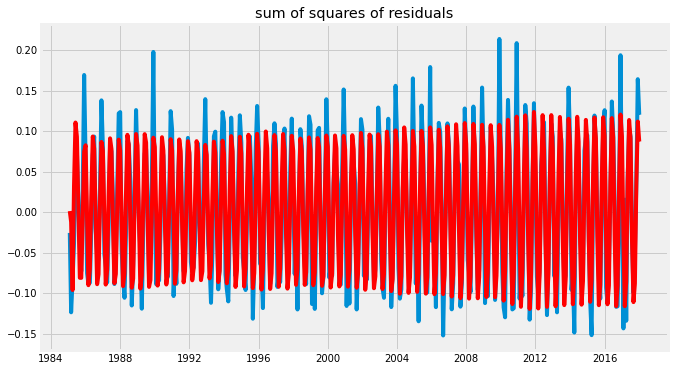

In [28]:
"""
What suggests AR(q) terms in a model?

ACF shows a decay
PACF cuts off quickly

What suggests MA(p) terms in a model?
ACF cuts off sharply
PACF decays gradually

In PACF, the plot crosses the first dashed line(95% confidence interval line) around lag 2 hence p=2
"""

model = ARIMA(df_log, order=(3, 1, 3))
result_AR = model.fit(disp=0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' % sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))
# RSS : 0.5227

# less the RSS more effective the model is

In [29]:
"""
forecast electricity consumption for next 4 months
"""
"""
future=df_log
future=future.reset_index()
mon=future["Date"]
mon=mon+pd.DateOffset(months=7)
future_dates = mon[-7-1:]
future = future.set_index('Date')
newDf = pd.DataFrame(index=future_dates, columns=future.columns)
future = pd.concat([future,newDf])
future["Forecast Consumption"]= result_AR.predict(start=35, end =43, dynamic=True)
future["Forecast Consumption"].iloc[-10:]=result_AR.forecast(steps=10)[0]
future[['Consumption','Forecast Consumption']].plot()
"""

# we founded the predicted values in the above code and we need to print the values in the form of series
ARIMA_predicts = pd.Series(result_AR.fittedvalues, copy=True)
ARIMA_predicts.head()

# finding the cummulative sum
ARIMA_predicts_cumsum = ARIMA_predicts.cumsum()
print(ARIMA_predicts_cumsum.head())

Date
1985-02-01    0.001384
1985-03-01   -0.010687
1985-04-01   -0.106838
1985-05-01   -0.074157
1985-06-01    0.036631
dtype: float64


In [30]:
ARIMA_predicts_log = pd.Series(df_log['Consumption'], index=df_log.index)
ARIMA_predicts_log = ARIMA_predicts_log.add(
    ARIMA_predicts_cumsum, fill_value=0)
print(ARIMA_predicts_log.head())

Date
1985-01-01    4.283658
1985-02-01    4.259434
1985-03-01    4.123682
1985-04-01    3.944450
1985-05-01    3.938889
dtype: float64


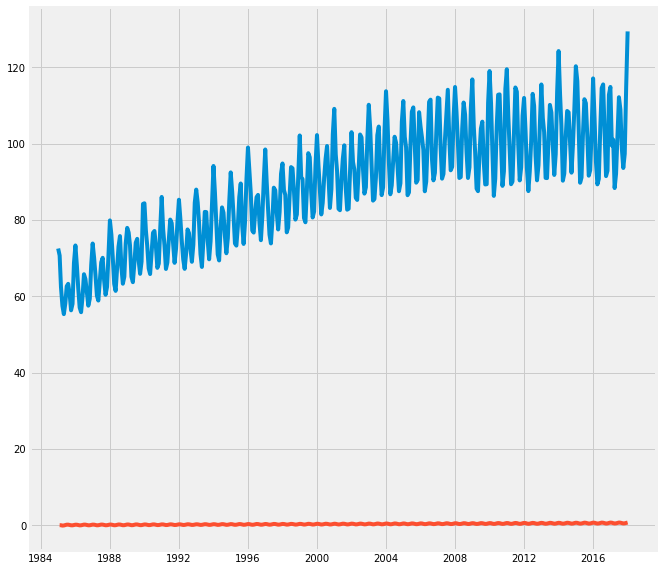

In [33]:
# converting back to the exponential form results in getting back to the original data.
ARIMA_final_preditcs = np.exp(ARIMA_predicts_log)
rcParams['figure.figsize'] = 10, 10
plt.plot(df)
plt.plot(ARIMA_predicts_cumsum)

#plt.plot(ARIMA_predicts_cumsum)
#plt.plot(df)

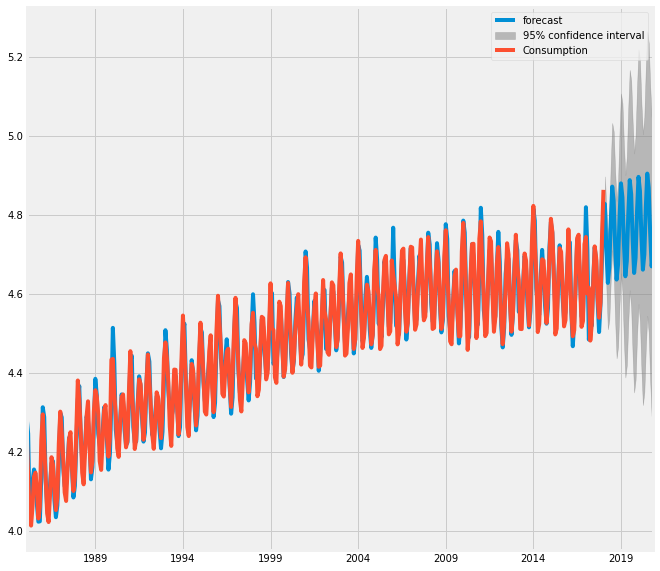

In [42]:

# future prediction
result_AR.plot_predict(1, 430)
x = result_AR.forecast(steps=200)

# from the above graph, we calculated the future predictions till 2024
# the greyed out area is the confidence interval wthe predictions will not cross that area.

# Finally we calculated the units(value) of electricity is consumed in the coming future using time series analysis.

# References

- https://www.kdnuggets.com/2020/01/predict-electricity-consumption-time-series-analysis.html
- https://github.com/nageshsinghc4/Time-Series-Analysis